In [1]:
default_installations = True

if default_installations:
    !pip -q install datasets num2words autocorrect
else:
    import requests

    text_file_path = "requirements__Ch5_Text_Classification_Traditional_ML.txt"
    url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter5_notebooks/" + text_file_path
    res = requests.get(url)
    with open(text_file_path, "w") as f:
        f.write(res.text)

    !pip install -r requirements__Ch5_Text_Classification_Traditional_ML.txt

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
from datasets import load_dataset
from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/llouis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/llouis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/llouis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
config_dict = {'db_name': "zeroshot/twitter-financial-news-topic",
               'do_preprocessing': True,
               'do_enhanced_preprocessing': False,
               'do_feature_eng': True,
               'maximize_a_priori': True,
               'num_chosen_features_per_class': 200,
               'test_size': 0.2,
               'feature_eng_details': "CountVectorizer-binary",
               'ngram_range_min': 1,
               'ngram_range_max': 2,
               'max_features': 1000,
               'seed': 0}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [7]:
dataset_raw = load_dataset(config_dict["db_name"])

Generating validation split: 100%|██████████| 4117/4117 [00:00<00:00, 408351.26 examples/s]


In [8]:
first_df = pd.DataFrame(dataset_raw["train"])
second_df = pd.DataFrame(dataset_raw["validation"])
dataset_df = pd.concat([first_df, second_df]).reset_index(drop=True)
dataset_df = dataset_df.rename(columns={"label": "_label_"})

In [9]:
dataset_df.head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,"Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon & more https://t.co/QPN8Gwl7Uh",0
1,"Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says https://t.co/fLS2w57iCz",0
2,"Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition https://t.co/1EmtywmYpr",0
3,"Analysts react to Tesla's latest earnings, break down what's next for electric car maker https://t.co/kwhoE6W06u",0
4,"Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside https://t.co/jPpdl0D9s4",0
5,Barclays believes earnings for these underperforming stocks may surprise Wall Street https://t.co/PHbsyVGAyE,0
6,"Bernstein upgrades Alibaba, says shares can rally more than 20% from here https://t.co/m3ApoPRGU0",0
7,"Analysts react to Netflix's strong quarter, with some pointing to a potential bottom for the stock https://t.co/cQngJsyefD",0
8,"Buy Chevron as shares look attractive at these levels, HSBC says https://t.co/GkDpFvxjEP",0
9,Morgan Stanley says these global stocks are set for earnings beats — and gives one over 45% upside https://t.co/GeWxa5YoWr,0


In [10]:
print("원본 레이블 분포:\n")
dataset_df[["_label_"]].value_counts()

원본 레이블 분포:



_label_
2          4397
18         2646
14         2237
9          1893
16         1234
5          1229
1          1051
19         1020
7           784
6           670
15          626
17          607
12          606
13          587
4           456
3           398
0           328
8           198
10           82
11           58
Name: count, dtype: int64

In [11]:
dataset_df_binary = dataset_df.copy()
dataset_df_binary["_label_"] = dataset_df_binary["_label_"].map({2: 1}).fillna(0).map(int)

In [12]:
print("새로운 레이블의 분포:\n")
frequencies = dataset_df_binary[["_label_"]].value_counts()
frequencies

새로운 레이블의 분포:



_label_
0          16710
1           4397
Name: count, dtype: int64

In [13]:
most_frequent_class = frequencies.index[:][0][0]
print("가장 빈도가 높은 클래스는:", most_frequent_class)
print("해당 클래스의 기준 정확도는:", round((dataset_df_binary["_label_"] == most_frequent_class).mean(), 3))

가장 빈도가 높은 클래스는: 0
해당 클래스의 기준 정확도는: 0.792


In [14]:
def digits_to_words(match):
    suffixes = ['st', 'nd', 'rd', 'th']
    string = match[0].lower()
    if string[-2:] in suffixes:
        type = 'ordinal'
        string = string[:-2]
    else:
        type = 'cardinal'

    return num2words(string, to=type)


def spelling_correction(text):
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)


def remove_stop_words(text):
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])


def stemming(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])


def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def preprocessing(input_text):
    output = input_text
    output = output.lower()
    output = re.sub(r'http\S+', "", output)
    output = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, output, flags=re.IGNORECASE)
    output = re.sub('[^ A-Za-z0-9]+', '', output)
    if config_dict["do_enhanced_preprocessing"]:
        output = spelling_correction(output)
    output = remove_stop_words(output)
    if config_dict["do_enhanced_preprocessing"]:
        output = stemming(output)
        output = lemmatizing(output)
    return output

In [15]:
dataset_clean = dataset_df_binary.copy()
if config_dict["do_preprocessing"]:
    dataset_clean["text"] = [preprocessing(text) for text in dataset_clean["text"]]

In [16]:
dataset_clean.head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,thursdays biggest analyst calls apple amazon tesla palantir docusign exxon amp,0
1,buy las vegas sands travel singapore builds wells fargo says,0
2,piper sandler downgrades docusign sell citing elevated risks amid ceo transition,0
3,analysts react teslas latest earnings break whats next electric car maker,0
4,netflix peers set return growth analysts say giving one stock one hundred twenty upside,0
5,barclays believes earnings underperforming stocks may surprise wall street,0
6,bernstein upgrades alibaba says shares rally twenty,0
7,analysts react netflixs strong quarter pointing potential bottom stock,0
8,buy chevron shares look attractive levels hsbc says,0
9,morgan stanley says global stocks set earnings beats gives one fortyfive upside,0


In [17]:
!pip install -Uq koreanize-matplotlib
import koreanize_matplotlib

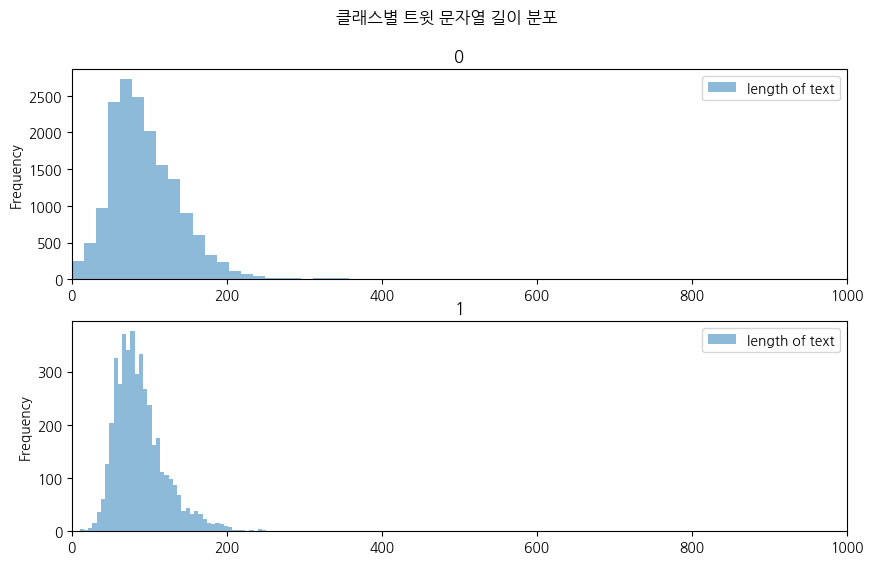

In [18]:
dataset_clean["length of text"] = dataset_clean["text"].map(len)
ax = dataset_clean.plot.hist(column=["length of text"], by="_label_", bins=50, alpha=0.5, figsize=(10, 6),
                             title="클래스별 트윗 문자열 길이 분포", xlim=[0, 1000])

In [19]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
    if "CountVectorizer-binary" == config_dict["feature_eng_details"]:
        print("특성 공학 방법: 이진 (원-핫 인코딩)")
        countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                          stop_words='english',
                                          max_features=config_dict["max_features"],
                                          binary=True)
    elif "CountVectorizer-BOW" == config_dict["feature_eng_details"]:
        print("특성 공학 방법: 단어 가방(Bag of Words)")
        countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                          stop_words='english',
                                          max_features=config_dict["max_features"],
                                          binary=False)
    out_arr = countvectorizer.fit_transform(in_df[text_col])
    count_tokens = countvectorizer.get_feature_names_out()
    out_df = pd.DataFrame(data=out_arr.toarray(), columns=count_tokens)
    out_df[labels_col] = list(in_df[labels_col])
    return out_df


if config_dict["do_feature_eng"]:
    dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', '_label_', config_dict)
else:
    dataset_feat_eng = dataset_clean.copy()

특성 공학 방법: 이진 (원-핫 인코딩)


In [20]:
dataset_feat_eng.head()

,aapl,ab,access,according,acquire,acquires,acquisition,action,activity,actual,...,yy,zeroeight,zerofive,zerofour,zeroone,zeroseven,zerosix,zerothree,zerotwo,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
dataset_feat_eng.describe().loc[['min', 'max', 'mean']]

,aapl,ab,access,according,acquire,acquires,acquisition,action,activity,actual,...,yy,zeroeight,zerofive,zerofour,zeroone,zeroseven,zerosix,zerothree,zerotwo,_label_
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
mean,0.00379,0.002653,0.003459,0.016582,0.003316,0.004074,0.007344,0.007154,0.002701,0.003459,...,0.003316,0.002511,0.00379,0.004785,0.004501,0.003459,0.002653,0.003411,0.004548,0.20832


In [22]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=config_dict["test_size"], random_state=config_dict['seed'])
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index)
dataset_feat_eng_test.shape, dataset_feat_eng_train.shape

((4221, 1001), (16886, 1001))

In [23]:
means_by_class = dataset_feat_eng_train.groupby(by=["_label_"]).mean().T.sort_index()
means_by_class.head()

_label_,0,1
aapl,0.004269,0.002830
ab,0.003146,0.000000
access,0.002397,0.007357
according,0.019847,0.004527
acquire,0.004269,0.000000


In [24]:
P_class = sorted([[c, np.mean(dataset_feat_eng["_label_"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "_label_"])
P_feature_inv = [[f, 1 / p] for f, p in P_feature]
P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))
P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
    for c in P_class_given_feature.columns:
        P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[
            feature_counter, 1].astype(float)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
P_class_given_feature.sort_values([0], ascending=False)[[0]].head(10)

_label_,0
latest updates,1.411439
gasoline,1.402971
spx esf,1.398410
encourages investors,1.393258
warning,1.390024
upside,1.380427
monthly distribution,1.375892
contact firm,1.373492
esf,1.373492
ago,1.372025


In [26]:
P_class_given_feature.sort_values([1], ascending=False)[[1]].head(10)

_label_,1
launches,4.718646
solution,4.386093
partnership,4.316795
announcement form,4.221977
form eightthree,4.221977
uk regulatory,4.121902
regulatory announcement,4.121902
plc,4.063799
partner,4.029674
cloud,3.981702


In [27]:
chosen_features = []
if config_dict["maximize_a_priori"] == True:
    classes = means_by_class.columns
    for c in classes:
        chosen_features += list(
            means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])
else:
    classes = P_class_given_feature.columns
    for c in classes:
        chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[
                                :config_dict["num_chosen_features_per_class"] + 1])
chosen_features = list(set(chosen_features))

In [28]:
chosen_features[:20]

['new york',
 'according',
 'appoints',
 'latest',
 'bond',
 'use',
 'said',
 'ecb',
 'apple',
 'bank',
 'oil',
 'products',
 'companys',
 'investor',
 'fix',
 'launch',
 'set',
 'sampp',
 'twentythree',
 'plc']

In [29]:
dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ["_label_"])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ["_label_"])
dataset_feat_eng_train_selected.head()

,new york,according,appoints,latest,bond,use,said,ecb,apple,bank,...,technologies,company,expansion,air,center,international,china,crude,spy,_label_
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
dataset_feat_eng_train_selected["_label_"].value_counts()

_label_
0    13352
1     3534
Name: count, dtype: int64

In [31]:
dataset_feat_eng_train_selected.head()

,new york,according,appoints,latest,bond,use,said,ecb,apple,bank,...,technologies,company,expansion,air,center,international,china,crude,spy,_label_
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]
x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]
x_features_train.shape, y_labels_train.shape, x_features_test.shape, y_labels_test.shape

((16886, 324), (16886,), (4221, 324), (4221,))

In [33]:
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=config_dict['seed'])))
models.append(
    ("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=config_dict['seed'])))
models.append(("SVM", SVC(gamma='auto', random_state=config_dict['seed'])))
results = []
names = []
best_mean_result = 0
best_std_result = 0
for name, model in models:
    kfold = StratifiedKFold()
    cv_results = cross_val_score(model, x_features_train, y_labels_train, scoring='accuracy', cv=kfold)
    results.append(cv_results)
    names.append(name)
    print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(
        round(np.std(cv_results), 3)))
    if (best_mean_result < np.mean(cv_results)) or \
            ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
        best_mean_result = np.mean(cv_results)
        best_std_result = np.std(cv_results)
        best_model_name = name
        best_model = model
print("\n최적의 모델은:\n" + best_model_name)

Random Forest: mean(accuracy)=0.837, std(accuracy)=0.036
LASSO: mean(accuracy)=0.847, std(accuracy)=0.02


/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=

KNN: mean(accuracy)=0.81, std(accuracy)=0.038
Decision Tree: mean(accuracy)=0.818, std(accuracy)=0.029
SVM: mean(accuracy)=0.796, std(accuracy)=0.005

최적의 모델은:
LASSO


/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_45064/2850331996.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  matplotlib.pyplot.boxplot(results, labels=names)


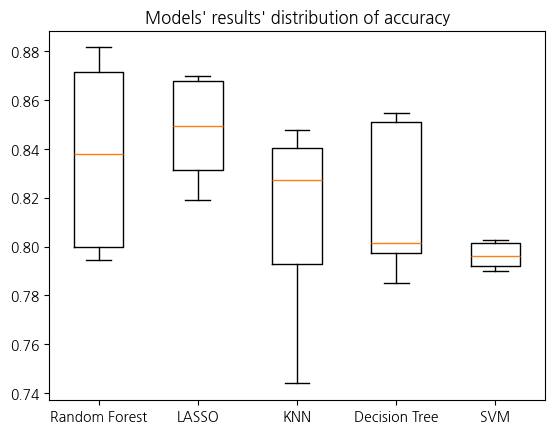

In [34]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Models' results' distribution of accuracy")
matplotlib.pyplot.show()

In [35]:
model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)
print("최적의 하이퍼파라미터 'C' 값은:", grid_search.best_params_["C"])

/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/pyconda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=

최적의 하이퍼파라미터 'C' 값은: 1.0535263157894736


In [36]:
model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=config_dict['seed'])
model.fit(x_features_train, y_labels_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",np.float64(1.0535263157894736)
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",0
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of p

In [37]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
accuracy_lift_train = 100 * (accuracy_train / baseline_accuracy_train - 1)
print("훈련 세트 결과:\n-------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_train, 2))
print("현재 모델의 정확도:", round(accuracy_train, 2))
print("정확도 향상은:", round(accuracy_lift_train), "%")

훈련 세트 결과:
-------------------------
기준 모델(더미 분류기) 정확도: 0.79
현재 모델의 정확도: 0.88
정확도 향상은: 11 %


In [38]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test / baseline_accuracy_test - 1)
print("테스트 세트 결과:\n-------------------------")
print("기준 모델(더미 분류기) 정확도:", round(baseline_accuracy_test, 2))
print("현재 모델의 정확도:", round(accuracy_test, 2))
print("정확도 향상은:", round(accuracy_lift), "%")
print("\n혼동 행렬(Confusion Matrix):")
print(confusion_matrix(y_labels_test, y_test_estimated))
print("\n분류 보고서(Classification Report):")
print(classification_report(y_labels_test, y_test_estimated))

테스트 세트 결과:
-------------------------
기준 모델(더미 분류기) 정확도: 0.8
현재 모델의 정확도: 0.87
정확도 향상은: 10 %

혼동 행렬(Confusion Matrix):
[[3228  130]
 [ 408  455]]

분류 보고서(Classification Report):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3358
           1       0.78      0.53      0.63       863

    accuracy                           0.87      4221
   macro avg       0.83      0.74      0.78      4221
weighted avg       0.87      0.87      0.86      4221

